In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import RegexpTokenizer, sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.tag import pos_tag, map_tag
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline

In [2]:
raw_pf_df = pd.read_csv('kaggle_poem_dataset.csv')
raw_pf_df['Author'] = raw_pf_df.Author.astype('category')
raw_pf_df.columns = [name.lower() for name in raw_pf_df.columns]
raw_pf_df = raw_pf_df.drop(['unnamed: 0', 'poetry foundation id'], axis=1)

In [3]:
print(raw_pf_df.content.head())

0    Dear Writers, I’m compiling the first in what ...
1    Philosophic\nin its complex, ovoid emptiness,\...
2    We'd  like  to  talk  with  you  about  fear t...
3    The Wise Men will unlearn your name.\nAbove yo...
4    For Jack Collom\n10 Things I do Every Day\n\np...
Name: content, dtype: object


In [4]:
# remove duplicates
print(raw_pf_df.info())
pf_df = raw_pf_df.copy().drop_duplicates(subset='content')
print(pf_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15638 entries, 0 to 15651
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   author   15638 non-null  category
 1   title    15638 non-null  object  
 2   content  15638 non-null  object  
dtypes: category(1), object(2)
memory usage: 552.0+ KB
None


In [5]:
# create function to clean lines
import string, re
from nltk.corpus import words
import multiprocessing as mp
def clean_text(text):
    text = text.lower()
    text = re.sub(' +', ' ', text)
    text = text.replace('\%','')
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
#     text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    tokens = text.split()
    text = " ".join(filter(lambda x:x[0]!="@", tokens))
    tokens = text.split()
    text = " ".join([s.strip(string.punctuation) for s in tokens])
    text = text.encode("ascii", "ignore").decode()
    return text.strip()

def clean_list(list_of_strings):
    return [clean_text(string) for string in list_of_strings if string]

In [7]:
# create column to store document as list of lines
pf_df['line'] = pf_df.content.str.split('\n')

#clean each line in the list of lines
pf_df['line'] = pf_df['line'].map(clean_list)

In [8]:
# remove empty lines for accurate line count
def remove_empty_lines(list_of_lines):
    try:
        return [i for i in list_of_lines if i]
    except TypeError:
        return pd.NA
    
pf_df['line'] = pf_df.line.map(remove_empty_lines)
print(pf_df.iloc[0])

author                                        Wendy Videlock
title                                                      !
content    Dear Writers, I’m compiling the first in what ...
line       [dear writers im compiling the first in what i...
Name: 0, dtype: object


In [9]:
# create column for length of poem in lines
pf_df['length_in_lines'] = pf_df.line.map(len)
pf_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15638 entries, 0 to 15651
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   author           15638 non-null  category
 1   title            15638 non-null  object  
 2   content          15638 non-null  object  
 3   line             15638 non-null  object  
 4   length_in_lines  15638 non-null  int64   
dtypes: category(1), int64(1), object(3)
memory usage: 796.3+ KB


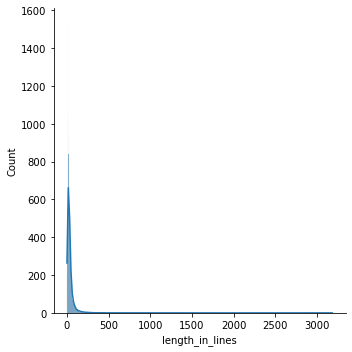

In [10]:
sns.displot(pf_df.length_in_lines, kde=True)

In [11]:
# filtering outliers with zscore
from scipy import stats
clean_df = pf_df[(np.abs(stats.zscore(pf_df.length_in_lines)) < 2)]

In [12]:
# filter sub-haiku length works and sentential logic prose poems
clean_df = clean_df[clean_df.length_in_lines > 2]

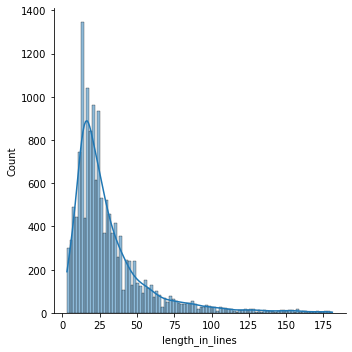

In [13]:
sns.displot(clean_df.length_in_lines, kde=True)

In [14]:
# create lexical diversity feature for each poem
def lexical_diversity(line_list):
    doc_string = ' '.join(line_list)
    words = word_tokenize(doc_string)
    return (len(set(words))/len(words))
        
clean_df['lexical_diversity'] = clean_df.line.map(lexical_diversity)

In [60]:
clean_df.head()

NameError: name 'clean_dfhead' is not defined

In [16]:
def lines2words(list_of_lines):
    text = list_of_lines
    while not isinstance(text, str):
        try:
            text = ' '.join(text)
        except TypeError:
            try:
                   text = ' '.join([item for sublist in text for item in sublist])
            except:
                print(f"problem with {text}")
    return text.split()


In [17]:
poems_corpus = clean_df.line.map(lines2words)
clean_df['words'] = poems_corpus

In [18]:
with open('poem_corpus.pkl', 'wb') as f:
    pickle.dump(poems_corpus, f)

In [19]:
def wds2len(list_of_words):
    return [len(word) for word in list_of_words]

test_list = ['hats','bats','gnats','cats','tats','catamarind']
print(wds2len(test_list))
clean_df['word_lengths'] = clean_df.words.map(wds2len)

[4, 4, 5, 4, 4, 10]


In [20]:
clean_df['max_word_length'] = clean_df.word_lengths.map(np.max)

In [21]:
print(clean_df.shape)
clean_df[['content', 'line', 'words', 'length_in_lines', 'lexical_diversity', 'word_lengths', 'max_word_length']].head()

(15065, 9)


,content,line,words,length_in_lines,lexical_diversity,word_lengths,max_word_length
1,"Philosophic\nin its complex, ovoid emptiness,\...","[philosophic, in its complex ovoid emptiness, ...","[philosophic, in, its, complex, ovoid, emptine...",15,0.863636,"[11, 2, 3, 7, 5, 9, 1, 8, 6, 6, 2, 2, 1, 4, 2,...",11
2,We'd like to talk with you about fear t...,[we'd like to talk with you about fear they sa...,"[we'd, like, to, talk, with, you, about, fear,...",11,0.644068,"[4, 4, 2, 4, 4, 3, 5, 4, 4, 4, 2, 4, 6, 4, 2, ...",10
3,The Wise Men will unlearn your name.\nAbove yo...,"[the wise men will unlearn your name, above yo...","[the, wise, men, will, unlearn, your, name, ab...",24,0.679739,"[3, 4, 3, 4, 7, 4, 4, 5, 4, 4, 2, 4, 4, 5, 3, ...",12
4,For Jack Collom\n10 Things I do Every Day\n\np...,"[for jack collom, things i do every day, play ...","[for, jack, collom, things, i, do, every, day,...",26,0.848101,"[3, 4, 6, 6, 1, 2, 5, 3, 4, 5, 5, 4, 5, 3, 4, ...",13
5,WINTER\nMore time is spent at the window.\n\nS...,"[winter, more time is spent at the window, sum...","[winter, more, time, is, spent, at, the, windo...",65,0.575843,"[6, 4, 4, 2, 5, 2, 3, 6, 6, 3, 2, 5, 4, 3, 2, ...",11


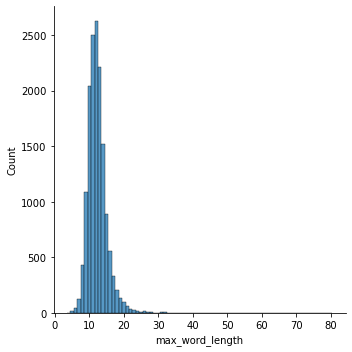

In [22]:
sns.displot(clean_df.max_word_length, discrete=True)

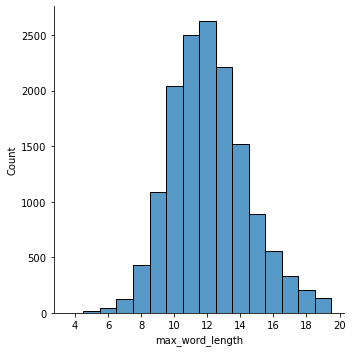

In [23]:
cleanest_df = clean_df[clean_df.max_word_length < 20]
sns.displot(cleanest_df.max_word_length, discrete=True)

In [24]:
with open('clean_df.pkl', 'wb') as f:
    pickle.dump(cleanest_df, f)

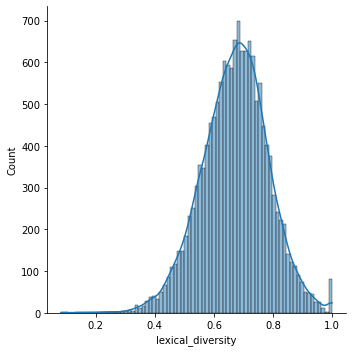

In [25]:
sns.displot(cleanest_df.lexical_diversity, kde=True)

In [26]:
cleanest_df.head()

,author,title,content,line,length_in_lines,lexical_diversity,words,word_lengths,max_word_length
1,Hailey Leithauser,0,"Philosophic\nin its complex, ovoid emptiness,\...","[philosophic, in its complex ovoid emptiness, ...",15,0.863636,"[philosophic, in, its, complex, ovoid, emptine...","[11, 2, 3, 7, 5, 9, 1, 8, 6, 6, 2, 2, 1, 4, 2,...",11
2,Jody Gladding,1-800-FEAR,We'd like to talk with you about fear t...,[we'd like to talk with you about fear they sa...,11,0.644068,"[we'd, like, to, talk, with, you, about, fear,...","[4, 4, 2, 4, 4, 3, 5, 4, 4, 4, 2, 4, 6, 4, 2, ...",10
3,Joseph Brodsky,1 January 1965,The Wise Men will unlearn your name.\nAbove yo...,"[the wise men will unlearn your name, above yo...",24,0.679739,"[the, wise, men, will, unlearn, your, name, ab...","[3, 4, 3, 4, 7, 4, 4, 5, 4, 4, 2, 4, 4, 5, 3, ...",12
4,Ted Berrigan,3 Pages,For Jack Collom\n10 Things I do Every Day\n\np...,"[for jack collom, things i do every day, play ...",26,0.848101,"[for, jack, collom, things, i, do, every, day,...","[3, 4, 6, 6, 1, 2, 5, 3, 4, 5, 5, 4, 5, 3, 4, ...",13
5,Joe Brainard,30 One-Liners,WINTER\nMore time is spent at the window.\n\nS...,"[winter, more time is spent at the window, sum...",65,0.575843,"[winter, more, time, is, spent, at, the, windo...","[6, 4, 4, 2, 5, 2, 3, 6, 6, 3, 2, 5, 4, 3, 2, ...",11


In [27]:
line_df = cleanest_df.drop(['length_in_lines', 'content','lexical_diversity', 'word_lengths', 'words', 'max_word_length'],axis=1).explode('line')
line_df = line_df.reset_index(drop=True)

In [28]:
line_df['line_no'] = line_df.groupby(['author',"title"]).cumcount()+1

In [29]:
line_df.head()

,author,title,line,line_no
0,Hailey Leithauser,0,philosophic,1
1,Hailey Leithauser,0,in its complex ovoid emptiness,2
2,Hailey Leithauser,0,a skillful pundit coined it as a sort,3
3,Hailey Leithauser,0,of stopgap doorstop for those,4
4,Hailey Leithauser,0,quaint equations,5


In [30]:
line_df['words'] = line_df.line.map(str.split)
line_df.head()

,author,title,line,line_no,words
0,Hailey Leithauser,0,philosophic,1,[philosophic]
1,Hailey Leithauser,0,in its complex ovoid emptiness,2,"[in, its, complex, ovoid, emptiness]"
2,Hailey Leithauser,0,a skillful pundit coined it as a sort,3,"[a, skillful, pundit, coined, it, as, a, sort]"
3,Hailey Leithauser,0,of stopgap doorstop for those,4,"[of, stopgap, doorstop, for, those]"
4,Hailey Leithauser,0,quaint equations,5,"[quaint, equations]"


In [31]:
line_df['length_in_words'] = line_df.words.map(len)

In [32]:
line_df.describe()
len(line_df.loc[line_df.length_in_words == 606].words.to_list()[0])

606

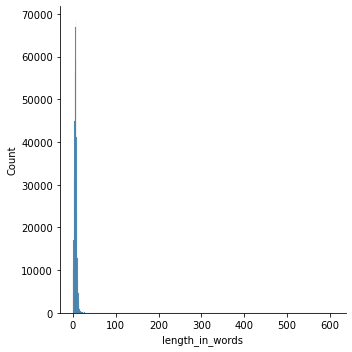

In [33]:
x = line_df.length_in_words
sns.displot(data=line_df, x='length_in_words', discrete=True)

In [34]:
# filtering outliers with zscore
from scipy import stats
clean_line_df = line_df[(np.abs(stats.zscore(line_df.length_in_words)) < 2)].copy()

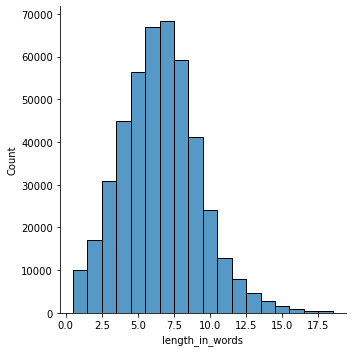

In [35]:
# fig, ax = plt.subplots()
# x = clean_line_df.length_in_words
sns.displot(data=clean_line_df, x='length_in_words', discrete=True)
# plt.tight_layout()

In [36]:
line_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453772 entries, 0 to 453771
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   author           453772 non-null  category
 1   title            453772 non-null  object  
 2   line             453772 non-null  object  
 3   line_no          453772 non-null  int64   
 4   words            453772 non-null  object  
 5   length_in_words  453772 non-null  int64   
dtypes: category(1), int64(2), object(3)
memory usage: 18.3+ MB


In [65]:
clean_line_df.head()

,author,title,line,line_no,words,length_in_words,lexical_diversity,word_lengths,max_word_length
0,Hailey Leithauser,0,philosophic,1,[philosophic],1,1.000,[11],11
1,Hailey Leithauser,0,in its complex ovoid emptiness,2,"[in, its, complex, ovoid, emptiness]",5,1.000,"[2, 3, 7, 5, 9]",9
2,Hailey Leithauser,0,a skillful pundit coined it as a sort,3,"[a, skillful, pundit, coined, it, as, a, sort]",8,0.875,"[1, 8, 6, 6, 2, 2, 1, 4]",8
3,Hailey Leithauser,0,of stopgap doorstop for those,4,"[of, stopgap, doorstop, for, those]",5,1.000,"[2, 7, 8, 3, 5]",8
4,Hailey Leithauser,0,quaint equations,5,"[quaint, equations]",2,1.000,"[6, 9]",9


In [67]:
clean_line_df['lexical_diversity'] = clean_line_df.words.map(lexical_diversity)
clean_line_df['word_lengths'] = clean_line_df.words.map(wds2len)

In [66]:
clean_line_df['max_word_length'] = clean_line_df.word_lengths.map(np.max)
cleanest_line_df = clean_line_df[(stats.zscore(clean_line_df.max_word_length)) < 1.75].copy()

In [42]:
cleanest_df.drop(['content','line','words'],axis=1)

,author,title,length_in_lines,lexical_diversity,word_lengths,max_word_length
1,Hailey Leithauser,0,15,0.863636,"[11, 2, 3, 7, 5, 9, 1, 8, 6, 6, 2, 2, 1, 4, 2,...",11
2,Jody Gladding,1-800-FEAR,11,0.644068,"[4, 4, 2, 4, 4, 3, 5, 4, 4, 4, 2, 4, 6, 4, 2, ...",10
3,Joseph Brodsky,1 January 1965,24,0.679739,"[3, 4, 3, 4, 7, 4, 4, 5, 4, 4, 2, 4, 4, 5, 3, ...",12
4,Ted Berrigan,3 Pages,26,0.848101,"[3, 4, 6, 6, 1, 2, 5, 3, 4, 5, 5, 4, 5, 3, 4, ...",13
5,Joe Brainard,30 One-Liners,65,0.575843,"[6, 4, 4, 2, 5, 2, 3, 6, 6, 3, 2, 5, 4, 3, 2, ...",11
...,...,...,...,...,...,...
15647,Hannah Gamble,Your Invitation to a Modest Breakfast,27,0.625551,"[3, 3, 4, 2, 5, 7, 3, 2, 3, 4, 4, 3, 4, 2, 5, ...",9
15648,Eleni Sikelianos,Your Kingdom\n \n \n \n Launch Audio in a N...,35,0.716418,"[2, 3, 4, 3, 3, 4, 4, 3, 3, 3, 9, 6, 7, 8, 3, ...",14
15649,Susan Elizabeth Howe,“Your Luck Is About To Change”,25,0.756579,"[1, 7, 6, 7, 11, 7, 4, 2, 3, 4, 6, 9, 11, 2, 1...",15
15650,Andrew Shields,Your Mileage May Vary,4,0.733333,"[3, 4, 5, 2, 3, 5, 3, 3, 3, 4, 4, 3, 4, 2, 3, ...",9


In [69]:
with open('clean_line_df.pkl', 'wb') as f:
    pickle.dump(cleanest_line_df, f)

In [68]:
cleanest_line_df.head()

,author,title,line,line_no,words,length_in_words,lexical_diversity,word_lengths,max_word_length
0,Hailey Leithauser,0,philosophic,1,[philosophic],1,1.000,[11],11
1,Hailey Leithauser,0,in its complex ovoid emptiness,2,"[in, its, complex, ovoid, emptiness]",5,1.000,"[2, 3, 7, 5, 9]",9
2,Hailey Leithauser,0,a skillful pundit coined it as a sort,3,"[a, skillful, pundit, coined, it, as, a, sort]",8,0.875,"[1, 8, 6, 6, 2, 2, 1, 4]",8
3,Hailey Leithauser,0,of stopgap doorstop for those,4,"[of, stopgap, doorstop, for, those]",5,1.000,"[2, 7, 8, 3, 5]",8
4,Hailey Leithauser,0,quaint equations,5,"[quaint, equations]",2,1.000,"[6, 9]",9


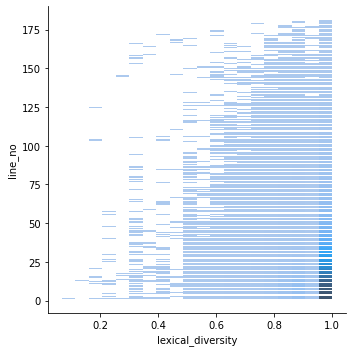

In [45]:
sns.displot(data=cleanest_line_df, x="lexical_diversity", y="line_no")

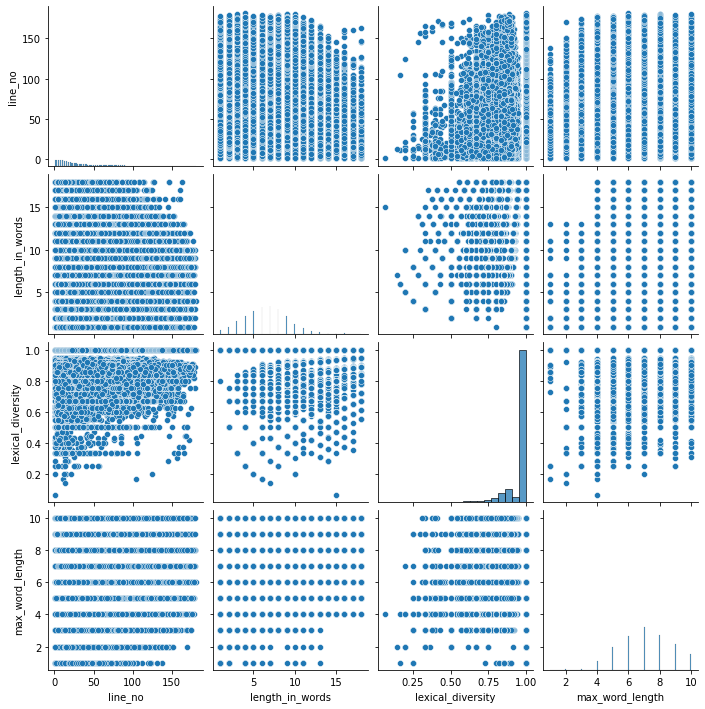

In [46]:
sns.pairplot(data=cleanest_line_df.drop(['author','title','line','words','word_lengths'], axis=1))

In [47]:
line_lexical = cleanest_line_df.drop(['line','words','word_lengths'], axis=1)

<AxesSubplot:xlabel='lexical_diversity', ylabel='length_in_words'>

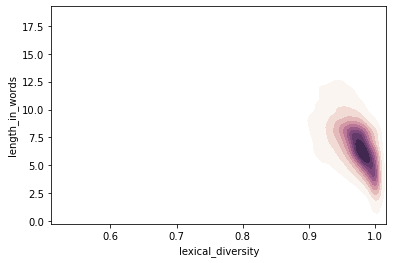

In [48]:
# author_line_lexical.reset_index(inplace=True)
cmap = sns.cubehelix_palette(light=1, as_cmap=True)

sns.kdeplot(data=line_lexical.groupby(['author','title']).mean(), x='lexical_diversity',y='length_in_words', cmap=cmap, fill=True)

In [49]:
line_lexical.describe()

,line_no,length_in_words,lexical_diversity,max_word_length
count,411540.000000,411540.000000,411540.000000,411540.000000
mean,26.920819,6.574486,0.971830,7.093029
std,27.423753,2.708600,0.068276,1.677748
min,1.000000,1.000000,0.066667,1.000000
25%,8.000000,5.000000,1.000000,6.000000
50%,18.000000,7.000000,1.000000,7.000000
75%,35.000000,8.000000,1.000000,8.000000
max,181.000000,18.000000,1.000000,10.000000


In [50]:
# initialize pipeline for tagging
import spacy
tag_nlp = spacy.load("en_core_web_sm", exclude=["parser", "attribute_ruler", "lemmatizer", "ner"])

In [51]:
tag_nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x23488ad2180>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x23488ab0b80>)]

In [52]:
# define tag pipe function
from tqdm import tqdm
def tag_pipe(texts):
    total = len(texts)
    pipe_out = []
    with tqdm(total=total) as pbar:
        for doc in tag_nlp.pipe(texts):
            pipe_out.append([str(token.tag_) for token in doc])
    return pipe_out

In [53]:
# populate part of speech tag column for lines
cleanest_line_df['pos_tags'] = tag_pipe(cleanest_line_df.line)
cleanest_line_df.head()

  0%|          | 0/411540 [01:52<?, ?it/s]


,author,title,line,line_no,words,length_in_words,lexical_diversity,word_lengths,max_word_length,pos_tags
1,Hailey Leithauser,0,in its complex ovoid emptiness,2,"[in, its, complex, ovoid, emptiness]",5,1.000,"[2, 3, 7, 5, 9]",9,"[IN, PRP$, JJ, JJ, NN]"
2,Hailey Leithauser,0,a skillful pundit coined it as a sort,3,"[a, skillful, pundit, coined, it, as, a, sort]",8,0.875,"[1, 8, 6, 6, 2, 2, 1, 4]",8,"[DT, JJ, NN, VBD, PRP, IN, DT, NN]"
3,Hailey Leithauser,0,of stopgap doorstop for those,4,"[of, stopgap, doorstop, for, those]",5,1.000,"[2, 7, 8, 3, 5]",8,"[IN, NN, VBP, IN, DT]"
4,Hailey Leithauser,0,quaint equations,5,"[quaint, equations]",2,1.000,"[6, 9]",9,"[NN, NNS]"
5,Hailey Leithauser,0,romans never,6,"[romans, never]",2,1.000,"[6, 5]",6,"[NNS, RB]"


In [54]:
with open('tagged_lines_df.pkl', 'wb') as t:
    pickle.dump(cleanest_line_df, t)

In [55]:
# populate part of speech tag column for poems
clean_poems = cleanest_df.line.map(lambda lines:' '.join(lines)).to_list()
cleanest_df['pos_tags'] = tag_pipe(clean_poems)

  0%|          | 0/14740 [01:23<?, ?it/s]
<ipython-input-55-aab6d35203da>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanest_df['pos_tags'] = tag_pipe(clean_poems)


In [62]:
cleanest_df.drop(['author','title','content', 'words'], axis=1).head()

,line,length_in_lines,lexical_diversity,word_lengths,max_word_length,pos_tags
1,"[philosophic, in its complex ovoid emptiness, ...",15,0.863636,"[11, 2, 3, 7, 5, 9, 1, 8, 6, 6, 2, 2, 1, 4, 2,...",11,"[JJ, IN, PRP$, JJ, JJ, NN, DT, JJ, NN, VBD, PR..."
2,[we'd like to talk with you about fear they sa...,11,0.644068,"[4, 4, 2, 4, 4, 3, 5, 4, 4, 4, 2, 4, 6, 4, 2, ...",10,"[PRP, MD, VB, TO, VB, IN, PRP, IN, NN, PRP, VB..."
3,"[the wise men will unlearn your name, above yo...",24,0.679739,"[3, 4, 3, 4, 7, 4, 4, 5, 4, 4, 2, 4, 4, 5, 3, ...",12,"[DT, JJ, NNS, MD, VB, PRP$, NN, IN, PRP$, NN, ..."
4,"[for jack collom, things i do every day, play ...",26,0.848101,"[3, 4, 6, 6, 1, 2, 5, 3, 4, 5, 5, 4, 5, 3, 4, ...",13,"[IN, JJ, NN, NNS, PRP, VBP, DT, NN, VB, NN, VB..."
5,"[winter, more time is spent at the window, sum...",65,0.575843,"[6, 4, 4, 2, 5, 2, 3, 6, 6, 3, 2, 5, 4, 3, 2, ...",11,"[NN, JJR, NN, VBZ, VBN, IN, DT, NN, NN, PRP, V..."


In [57]:
with open('tagged_poems_df.pkl', 'wb') as t2:
    pickle.dump(cleanest_df, t2)

In [58]:
# author_line_lexical_mode = clean_line_df.drop(['title','line','words'], axis=1).groupby('author').mode()
# author_line_lexical_mode.reset_index(inplace=True)
# sns.displot(data=author_line_lexical_avg, x='length_in_words',y='lexical_diversity')

In [40]:
from collections import Counter
wl_freq_dists = cleanest_df.word_lengths.map(Counter)
wl_fd_df = wl_freq_dists.apply(pd.Series).add_prefix('wl_count_').fillna(0)

In [64]:
big_df = pd.concat([cleanest_df, wl_freq_dists], axis=1).drop('word_lengths', axis=1)

In [63]:
with open('full_df.pkl', 'wb') as wlf:
    pickle.dump(big_df, wlf)